In [1]:
from pynq import MMIO
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from ad9361 import AD9361

In [2]:
adc = AD9361()

ad9361 successfully initialized
product ID: 0xA


In [3]:
ol = adc.ol

In [4]:
sample_rate = 40000000
data_point_size = 1024 # One Channel with data I number, 16bitdata_point_size*2
mmio0 = ol.axi_litev3_0.mmio
mmio1 = ol.pack_v1_0_0.mmio
switch0 = ol.channel_1.axis_switch_0.mmio
switch1 = ol.channel_2.axis_switch_1.mmio
dma0 = ol.axi_dma_0
dma1 = ol.axi_dma_1

### AD_DA_top

In [5]:
mmio0.write(0x8, 0)
mmio0.write(0xc, 256)
mmio0.write(0x10, 1)
mmio0.write(0x14, sample_rate << 2)
mmio0.write(0x54, 0x7f)
mmio0.write(0x58, 12)
mmio0.write(0x4, 1)

### SWITCH

In [6]:
switch0.write(0x40,1)
switch0.write(0x44,0)
switch0.write(0x48,0x80000000)
switch0.write(0x00,2)

switch1.write(0x40,1)
switch1.write(0x44,0)
switch1.write(0x48,0x80000000)
switch1.write(0x00,2)

### AXI_DMA

In [7]:
buffer0 = allocate(shape=(data_point_size*2,), dtype = np.int16)
buffer1 = allocate(shape=(data_point_size*2,), dtype = np.int16)

In [8]:
dma0.recvchannel.transfer(buffer0)
dma1.recvchannel.transfer(buffer1)

In [9]:
dma0.recvchannel.idle
dma1.recvchannel.idle

False

### PACK

In [10]:
mmio1.write(0x4, data_point_size)
mmio1.write(0x8, data_point_size)
mmio1.write(0x0, 0)
mmio1.write(0x0, 1) #Start capture data from ADC
mmio1.write(0x0, 0)

In [11]:
dma0.recvchannel.idle
dma1.recvchannel.idle

True

In [12]:
channel1_data_i = [0]*len(buffer0)
channel1_data_q = [0]*len(buffer0)
for i in range(0, len(buffer0)):
        if (i%2) == 0:
            channel1_data_i[i >> 1] = buffer0[i]
        else:
            channel1_data_q[(i-1) >> 1] = buffer0[i]

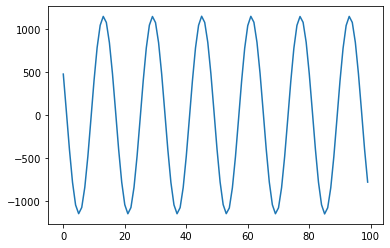

In [13]:
plt.plot(channel1_data_i[0:100])

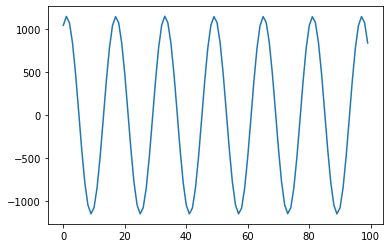

In [14]:
plt.plot(channel1_data_q[0:100])

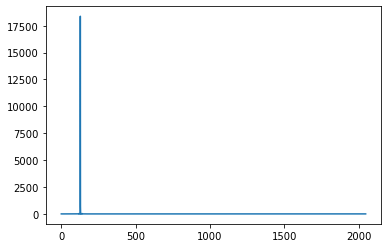

In [15]:
# switch to FFT
switch0.write(0x40,2)
switch0.write(0x44,0)
switch0.write(0x48,1)
switch0.write(0x00,2)

switch1.write(0x40,2)
switch1.write(0x44,0)
switch1.write(0x48,1)
switch1.write(0x00,2)

dma0.recvchannel.transfer(buffer0)
dma1.recvchannel.transfer(buffer1)

mmio1.write(0x4, 1024)
mmio1.write(0x8, 1024)
mmio1.write(0x0, 0)
mmio1.write(0x0, 1)
mmio1.write(0x0, 0)

plt.plot(np.abs(buffer0))

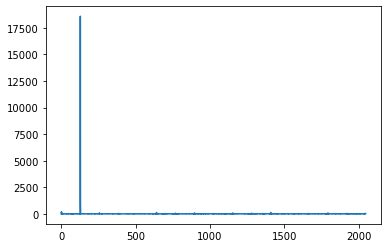

In [16]:
plt.plot(np.abs(buffer1))

In [17]:
ol.free()